# Basic Models in TensorFlow

## Agenda
* Liner regression in TensorFlow
* Optimizers
* Logistic regression on MNIST
* Loss functions

## 振り返り
### graphの計算
* TensorFlowは計算の定義とその実行を分けている
    * Phase1: graph を組み立てる
    * Phase2: graphの演算を実行するために、sessionを使用する

In [2]:
# TensorBoardはFileWriterオブジェクトを生成することでgraphをevent fileに書き出すことができる

import tensorflow as tf
a = 2 
b = 3 
x = tf.add(a, b)
y = tf.multiply(a, b)
useless = tf.multiply(a, x)
z = tf.pow(y, x)
with tf.Session() as sess:
    z = sess.run(z)

### tf.constant と tf.Variables
* Constant valueがgraph定義にストアされる
* Sessionはストアする変数にメモリを割り当てる

### tf.placeholder と feed_dict
* 値を辞書型によってplaceholderに与えることができる
* variablesにも同様に入れることができる

### Lazy loading を避ける
* graphの組み立てとopsの実行を分ける
* 関数が呼び出された際の一度だけloadされることを保証するためにPythonのattributeを使用する

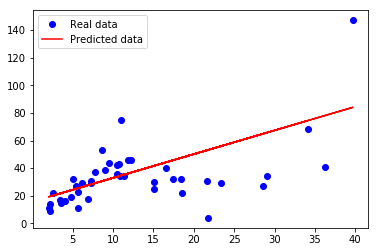

In [34]:
"""
Simple linear regression example in TensorFlow
This program tries to predict the number of thefts from 
the number of fire in the city of Chicago
"""

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import xlrd

DATA_FILE = '../data/fire_theft.xls'

# Phase 1: Assemble the graph
# Step 1: read in data from the .xls file
book = xlrd.open_workbook(DATA_FILE, encoding_override='utf-8')
sheet = book.sheet_by_index(0)
data = np.asarray([sheet.row_values(i) for i in range(1, sheet.nrows)])
n_samples = sheet.nrows - 1

# Step 2: create placeholders for input X (number of fire) and label Y (number of theft)
X = tf.placeholder(tf.float32, name="X")
Y = tf.placeholder(tf.float32, name="Y")

# Step 3: create weight and bias, initialized to 0
# name your variables w and b
w = tf.Variable(0.0, name="weight") 
b = tf.Variable(0.0, name="bias")

# Step 4: predict Y (number of theft) from the number of fire
# name your variable Y_predicted
Y_predicted = X * w + b

# Step 5: use the square error as the loss function
# name your variable loss
loss = tf.square(Y - Y_predicted, name="loss")

# Step 6: using gradient descent with learning rate of 0.01 to minimize loss
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001).minimize(loss)
 
# Phase 2: Train our model
with tf.Session() as sess:
    #writer = tf.summary.FileWriter('./my_graph/03/liner_reg', sess.graph)
    # Step 7: initialize the necessary variables, in this case, w and b
    sess.run(tf.global_variables_initializer())
    
    writer = tf.summary.FileWriter('./my_graph/03/linear_reg', sess.graph)
    # Step 8: train the model
    for i in range(100): # run 100 epochs
        total_loss = 0
        for x, y in data:
            # Session runs optimizer to minimize loss and fetch the value of loss
            _, l = sess.run([optimizer, loss], feed_dict={X: x, Y:y})
            total_loss += l
        #print("Epoch {0}: {1}".format(i, total_loss/n_samples))
    w, b = sess.run([w, b])

# plot the results
X, Y = data.T[0], data.T[1]
plt.plot(X, Y, 'bo', label='Real data')
plt.plot(X, X * w + b, 'r', label='Predicted data')
plt.legend()
plt.show()

## Discussion question
1. モデルの正しさをどうやって知るか？
2. モデルをどうやって改善するか？

上のoutputではあまりfitしていないように見える。。


## Huber loss
* ロバスト推定での回帰や、サポートベクトル回帰の損失関数として利用される。xが0から遠いところでは線形にしか増加しないため、はずれ値の影響が2次の損失関数と比べてずっと小さい。また、絶対損失と異なり、定義域全体で微分可能なため便利。

In [43]:
# Huber loss 関数
def huber_loss(labels, predictions, delta=1.0):
    residual = tf.abs(predictions - labels)
    condition = tf.less(residual, delta)
    small_res = 0.5 * tf.square(residual)
    large_res = delta * residual - 0.5 * tf.square(delta)
    return tf.where(condition, small_res, large_res)

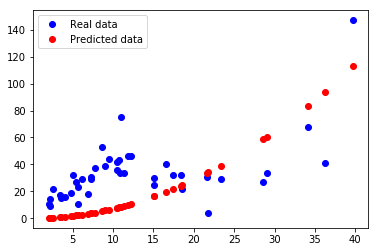

In [52]:
"""
quadratic function(二次関数)だとうまくいくだろうか?
"""

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import xlrd

DATA_FILE = '../data/fire_theft.xls'

# Phase 1: Assemble the graph
# Step 1: read in data from the .xls file
book = xlrd.open_workbook(DATA_FILE, encoding_override='utf-8')
sheet = book.sheet_by_index(0)
data = np.asarray([sheet.row_values(i) for i in range(1, sheet.nrows)])
n_samples = sheet.nrows - 1

# Step 2: create placeholders for input X (number of fire) and label Y (number of theft)
X = tf.placeholder(tf.float32, name="X")
Y = tf.placeholder(tf.float32, name="Y")

# Step 3: create weight and bias, initialized to 0
# name your variables w and b
w = tf.Variable(0.0, name="weights_1")
u = tf.Variable(0.0, name="weights_2")
b = tf.Variable(0.0, name="bias")

# Step 4: predict Y (number of theft) from the number of fire
# name your variable Y_predicted
Y_predicted = X * X * w + X * u + b

# Step 5: use the square error as the loss function
# name your variable loss
# Huber lossを使用する場合、
# Y - Y_predicted < delta の場合には描画できない
loss = tf.square(huber_loss(Y, Y_predicted, delta=0.01), name="loss")

# Step 6: using gradient descent with learning rate of 0.01 to minimize loss
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001).minimize(loss)
 
# Phase 2: Train our model
with tf.Session() as sess:
    #writer = tf.summary.FileWriter('./my_graph/03/liner_reg', sess.graph)
    # Step 7: initialize the necessary variables, in this case, w and b
    sess.run(tf.global_variables_initializer())
    
    #writer = tf.summary.FileWriter('./my_graph/03/linear_reg', sess.graph)
    # Step 8: train the model
    for i in range(10): # run 10 epochs
        total_loss = 0
        for x, y in data:
            # Session runs optimizer to minimize loss and fetch the value of loss
            _, l = sess.run([optimizer, loss], feed_dict={X: x, Y:y})
            total_loss += l
        #print("Epoch {0}: {1}".format(i, total_loss/n_samples))
    w, u, b = sess.run([w, u, b])

# plot the results
X, Y = data.T[0], data.T[1]
plt.plot(X, Y, 'bo', label='Real data')
plt.plot(X, X * X * w + X * u + b, 'ro', label='Predicted data')
plt.legend()
plt.show()

線形関数よりも少ない回数で収束しました。しかし、まだ異常値のため完全ではありません。もしかしたら、関数fとしてMSEや3rd degree polynomialの代わりにHuber lossの方がよいのかもしれません。

2次関数モデルにHuber lossを使用することで、異常値の無視が少しだけよくなりました。

### モデルの正しさをどうやって知るか？
#### R2乗の相関係数を使用する
あなたが`R-squared`を知らないのであれば、Minitabが[blog post](http://blog.minitab.com/blog/adventures-in-statistics-2/regression-analysis-how-do-i-interpret-r-squared-and-assess-the-goodness-of-fit)で説明してくれています。

要点を言うと、
R-squared はデータがどの程度回帰線にフィットされているかの統計的尺度です。
